# Social Network Analysis - Breaking Hits
## Authors: Wing Yan Sang and Iman Singh
## Date: 12/12/2017

<p><a name="sections"></a></p>


## Sections
- <a href="#data_import"> Data Import</a><br>
- <a href="#graphs"> Network Graphs</a><br>
- <a href="#centrality"> Centrality</a><br>
 - <a href="#centrality1">Centrality Analysis 1: "Celebrities"</a><br>
 - <a href="#centrality2">Centrality Analysis 2: "Gossipmongers"</a><br>
 - <a href="#centrality3">Centrality Analysis 3: "Boundary Spanners"</a><br>
 - <a href="#centrality4">Centrality Analysis 4: "Gray Cardinals"</a><br>
 - <a href="#centrality5">Centrality Analysis 5: "Page Rank"</a><br>   
 - <a href="#centrality_summary">Centrality Analysis: Summary </a><br>   
- <a href="#ccc"> Cliques, Clusters, Components</a><br>
- <a href="#bimodal"> Bimodal Networks</a><br>

In [185]:
#import mysql.connector
import pandas as pd
import numpy as np
import mysql.connector as sql

from matplotlib import pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
import operator
%matplotlib inline

pd.options.display.max_rows = 1000

<p><a name="data_import"></a></p>
## Data Import

In [127]:
# This function pulls specified data from Breaking Hits MySQL server
# parameters: SQL 'table_name' as string, 'col_names' as list of strings
# returns: pandas dataframe with specified columns

def get_table(table_name, col_names):    
    cnx = sql.connect(user='breaking_read',
                                  password='(hHy;gTPMnet',
                                  host='206.225.82.147',
                                  database='breaking_livedb')
    cur = cnx.cursor()
    select_statement = 'SELECT ' + ', '.join(col_names) + ' FROM ' + table_name +';'
    cur.execute(select_statement)
    rows = cur.fetchall()                         # get all selected rows
    field_names = [i[0] for i in cur.description] # get all column names
    cnx.close() # close the sql connection

    table = pd.DataFrame(rows, columns=field_names)
    return table

In [128]:
#removes rows with missing data 

def dropMissing(df):
    df = df.replace('', np.nan, regex=True) #convert empty cells to nan
    df = df.dropna()
    return df


In [176]:
#converts object to int64 for first two cols in data frame. (assumes no missing values)

def convertInt(df):
    for col in df.columns[:2]:
        if (df[col].dtype == 'object'):
            df[col] = df[col].astype(int)
#    if (df[df.columns[2]].dtype == 'object'):
#        df[df.columns[2]] = df[df.columns[2]].astype('<M8[ns]')
    return df


In [177]:
# Parameters string specifying connection type: follow, message, view, sociallink, rating, save, spotlight, comment
# Returns formatted pandas dataframe

def get_dataframe(connection='follow'):  
    if (connection == 'follow'):
        df = get_table('user_following', ['followed_id', 'follower_id', 'date_followed'])
    elif (connection == 'sociallink'):
        df = get_table('bh_social_link_activity', ['user_id_shared', 'user', 'date_shared'])
    elif (connection == 'message'):
        df = get_table('bh_messenger', ['sendfrom', 'sendto', 'data_added', 'u_read'])
    elif (connection == 'view'):
        df = get_table('bh_music_views', ['artists_id', 'user_id', 'date_added'])
    elif (connection == 'rating'):
        df = get_table('user_music_votes', ['user_id', 'user_music_id', 'date_added', 'rating'])
    elif (connection == 'save'):
        df = get_table('user_saved', ['music_id', 'user_id', 'date_saved'])   
    elif (connection == 'spotlight'):
        df = get_table('user_spotlight', ['music_id', 'user_id', 'date_added'])   
    elif (connection == 'comment'):
        df = get_table('user_music_comments', ['user_music_id', 'user_id', 'date_added'])
    else:
        return
   
    #Drop missing rows and convert and convert object to int for each column:   
    df = dropMissing(df)
    df = convertInt(df)
    
    return df

In [178]:
def count_missing(df):
    count = (df.isnull().sum() + df.apply(lambda x: x.eq("").sum(), axis=0)) 
    perc = round(count/df.shape[0]*100,2)
    missing_df = pd.concat([count, perc], axis = 1)
    missing_df.columns =['Count', 'Percentage']
    return(missing_df)

In [190]:
def get_artcric_df():
# This function connects to Breaking Hits MySQL server and pulls the users data
# and returns tuple of TWO pandas dataframes:
# the first one is for the critics
# the second one for the dataframe of artists

  cnx = sql.connect(user='breaking_read',
                                password='(hHy;gTPMnet',
                                host='206.225.82.147',
                                database='breaking_livedb')
  cur = cnx.cursor()
  cur.execute('SELECT * FROM breaking_livedb.users')
  rows = cur.fetchall()                         # get all selected rows
  field_names = [i[0] for i in cur.description] # get all column names
  cnx.close() # close the sql connection

  all_users = pd.DataFrame(rows, columns=field_names)
  critics = all_users[all_users['is_artist'] == 0]
  artists = all_users[all_users['is_artist'] == 1]
  return(artists, critics)

In [191]:
# parameters: graph containing nodes to get lists for
# returns: two lists - artists, critics

def get_artcric_lists(G):    
    artists, critics = get_artcric_df()
    a = artists['id'].tolist()
    c = critics['id'].tolist()
    a_list = [x for x in a if x in set(G.nodes())] #list of artists
    c_list = [x for x in c if x in set(G.nodes())] #list of critics 
    return a_list, c_list

In [179]:
#call function to get graph and dataframes for all eight connection types
df_follow = get_dataframe('follow')
df_message = get_dataframe('message')
df_view = get_dataframe('view')
df_sociallink = get_dataframe('sociallink')
df_rating = get_dataframe('rating')
df_save = get_dataframe('save')
df_spotlight = get_dataframe('spotlight')
df_comment = get_dataframe('comment')

#Define function to filter graph object to only include those that are tagged as critic/artist and label
#nodes as critic/artist. No direction to the edges.
def filter_graph(G):
    G_reduced = nx.Graph(G.subgraph(get_artcric_list(G)))
    G_reduced = add_artcric_keys(G_reduced)
    return G_reduced

In [169]:
#examine missingness of the various dataframes:
connection = ['follow', 'message', 'view', 'sociallink', 'rating', 'save', 'spotlight', 'comment']
[print(count_missing(get_dataframe(i)),'\n') for i in connection]


               Count  Percentage
followed_id        0         0.0
follower_id        0         0.0
date_followed      0         0.0 

            Count  Percentage
sendfrom        0         0.0
sendto          0         0.0
data_added      0         0.0
u_read          0         0.0 

            Count  Percentage
artists_id      0         0.0
user_id         0         0.0
date_added      0         0.0 

                Count  Percentage
user_id_shared      0         0.0
user                0         0.0
date_shared         0         0.0 

               Count  Percentage
user_id            0         0.0
user_music_id      0         0.0
date_added         0         0.0
rating             0         0.0 

            Count  Percentage
music_id        0         0.0
user_id         0         0.0
date_saved      0         0.0 

            Count  Percentage
music_id        0         0.0
user_id         0         0.0
date_added      0         0.0 

               Count  Percentage
user_music

[None, None, None, None, None, None, None, None]

In [168]:
#examine column types for each data frame

connection = ['follow', 'message', 'view', 'sociallink', 'rating', 'save', 'spotlight', 'comment']

for i in connection:
    print(i, " dataframe", '\n')
    print(get_dataframe(i).dtypes)

follow  dataframe 

followed_id               int64
follower_id               int64
date_followed    datetime64[ns]
dtype: object
message  dataframe 

sendfrom               int64
sendto                 int64
data_added    datetime64[ns]
u_read                 int64
dtype: object
view  dataframe 

artists_id             int64
user_id                int64
date_added    datetime64[ns]
dtype: object
sociallink  dataframe 

user_id_shared             int64
user                       int64
date_shared       datetime64[ns]
dtype: object
rating  dataframe 

user_id           int64
user_music_id     int64
date_added       object
rating            int64
dtype: object
save  dataframe 

music_id               int64
user_id                int64
date_saved    datetime64[ns]
dtype: object
spotlight  dataframe 

music_id               int64
user_id                int64
date_added    datetime64[ns]
dtype: object
comment  dataframe 

user_music_id     int64
user_id           int64
date_added       obje

<p><a name="graphs"></a></p>
## Network Graphs

-- View Follow/Followed network 

-- Define function to filter graph to only include users tagged critics/artists and to add attribute artist/critic

In [113]:
#Draw edges between nodes of a graph or directed graph
#Parameters: graph object (directed or undirected), dataframe that contains network info
#Returns: graph object with edges drawn

def add_edges(G, df):
    for row in df.itertuples():
        if ('u_read' in list(df)):
            G.add_edge(row[1], row[2], date=row[3], read=row[4])
        elif ('rating' in list(df)):
            G.add_edge(row[1], row[2], date=row[3], rating=row[4])
        else:
            G.add_edge(row[2], row[1], date=row[3])
    return G

In [195]:
#define node attribute 'user_type' = artist or critic
def filter_graph_artcric(G):
    a_list, c_list = get_artcric_lists(G)

    s1 = a_list + c_list #combined list of critics and artists 
    s2 = list(set(s1) & set(G.nodes())) #list of people in G.nodes() and tagged as artist or critic
    
    G_reduced = nx.Graph(G.subgraph(s2))
    key_list = G_reduced.nodes()

    for i in range(0,len(key_list)): 
        if (key_list[i] in c_list):
            G_reduced.node[key_list[i]]['user_type'] = 'critic'
        else:
            G_reduced.node[key_list[i]]['user_type'] = 'artist'
    return G_reduced

In [196]:
#define node attribute 'user_type' = artist or critic
def filter_digraph_artcric(DG):
    a_list, c_list = get_artcric_lists(DG)

    s1 = a_list + c_list #combined list of critics and artists 
    s2 = list(set(s1) & set(DG.nodes())) #list of people in G.nodes() and tagged as artist or critic
    
    DG_reduced = nx.DiGraph(DG.subgraph(s2))
    key_list = DG_reduced.nodes()

    for i in range(0,len(key_list)): 
        if (key_list[i] in c_list):
            DG_reduced.node[key_list[i]]['user_type'] = 'critic'
        else:
            DG_reduced.node[key_list[i]]['user_type'] = 'artist'
    return DG_reduced

In [118]:
#implement filter function and draw the filtered graph

def get_colors_artcric(G):
    color_map = {}
    key_list = G.nodes()

    for i in range(0, len(key_list)):
        if(G.node[key_list[i]]['user_type'] == 'critic'):
            color_map[key_list[i]] = 'b'
        else:
            color_map[key_list[i]] = 'r'
    colors = [color_map.get(node) for node in G.nodes()]
    return colors

In [119]:
G_follow = add_edges(nx.Graph(), df_follow)
DG_follow = add_edges(nx.DiGraph(), df_follow)
G_message = add_edges(nx.Graph(), df_message)
DG_message = add_edges(nx.DiGraph(), df_message)
G_view = add_edges(nx.Graph(), df_view)
DG_view = add_edges(nx.DiGraph(), df_view)
G_sociallink = add_edges(nx.Graph(), df_sociallink)
DG_sociallink = add_edges(nx.DiGraph(), df_sociallink)

In [121]:
G_follow = filter_graph_artcric(G_follow)
DG_follow = filter_digraph_artcric(DG_follow)
G_message = filter_graph_artcric(G_message)
DG_message = filter_digraph_artcric(DG_message)
G_view = filter_graph_artcric(G_view)
DG_view = filter_digraph_artcric(DG_view)
G_sociallink = filter_graph_artcric(G_sociallink)
DG_sociallink = filter_digraph_artcric(DG_sociallink)

In [122]:
follow_colors = get_colors_artcric(G_follow)
message_colors = get_colors_artcric(G_message)
view_colors = get_colors_artcric(G_view)
sociallink_colors = get_colors_artcric(G_sociallink)

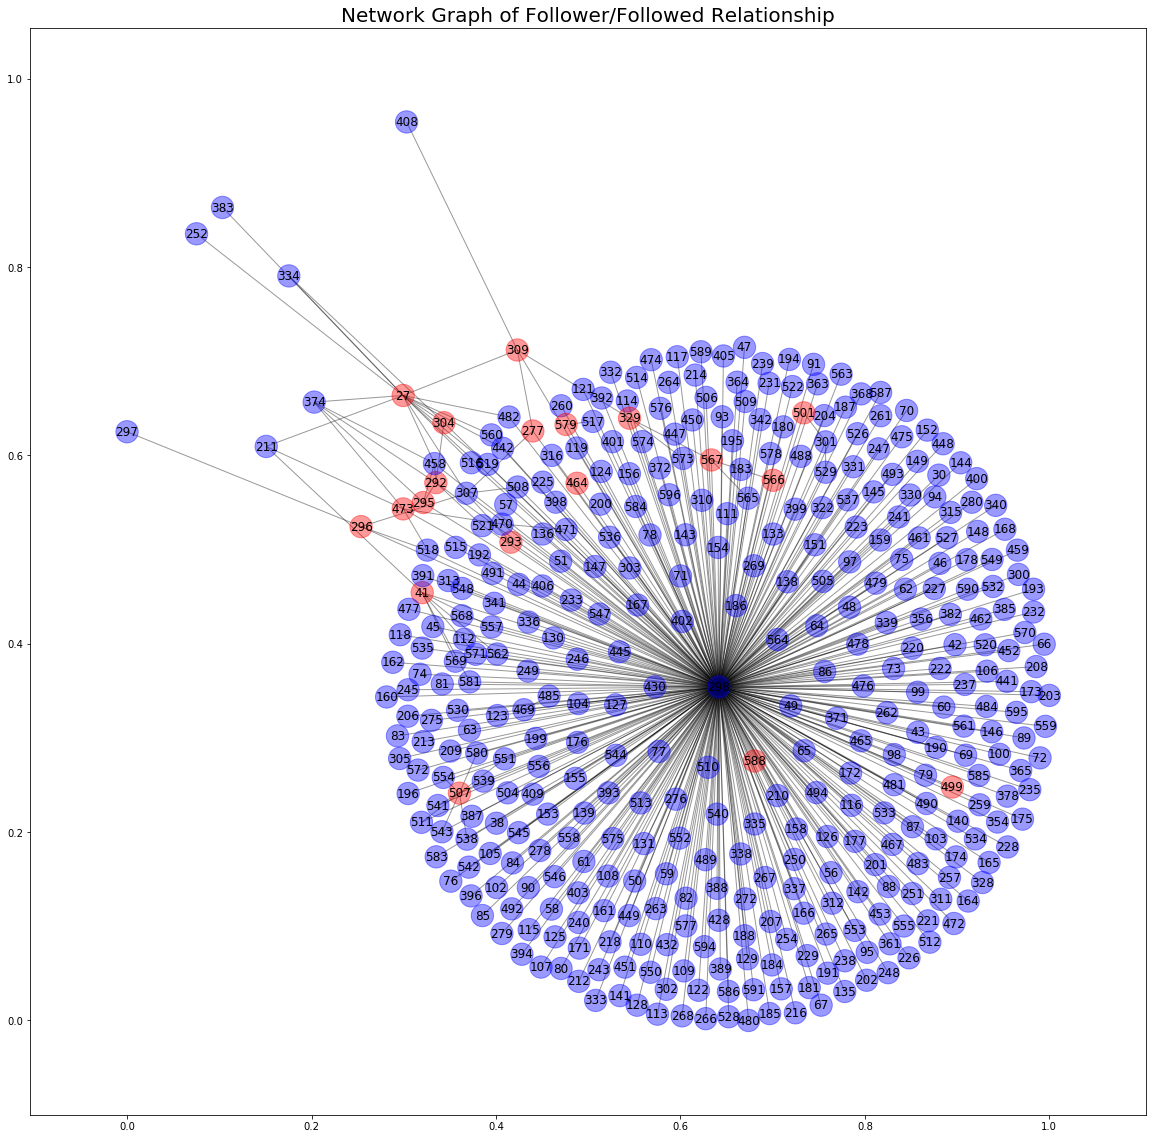

In [180]:
plt.figure(figsize=(20,20))
plt.title('Network Graph of Follower/Followed Relationship', fontsize = 20)
nx.draw_networkx(G_follow, node_color = follow_colors, node_size = 500, alpha = 0.4)

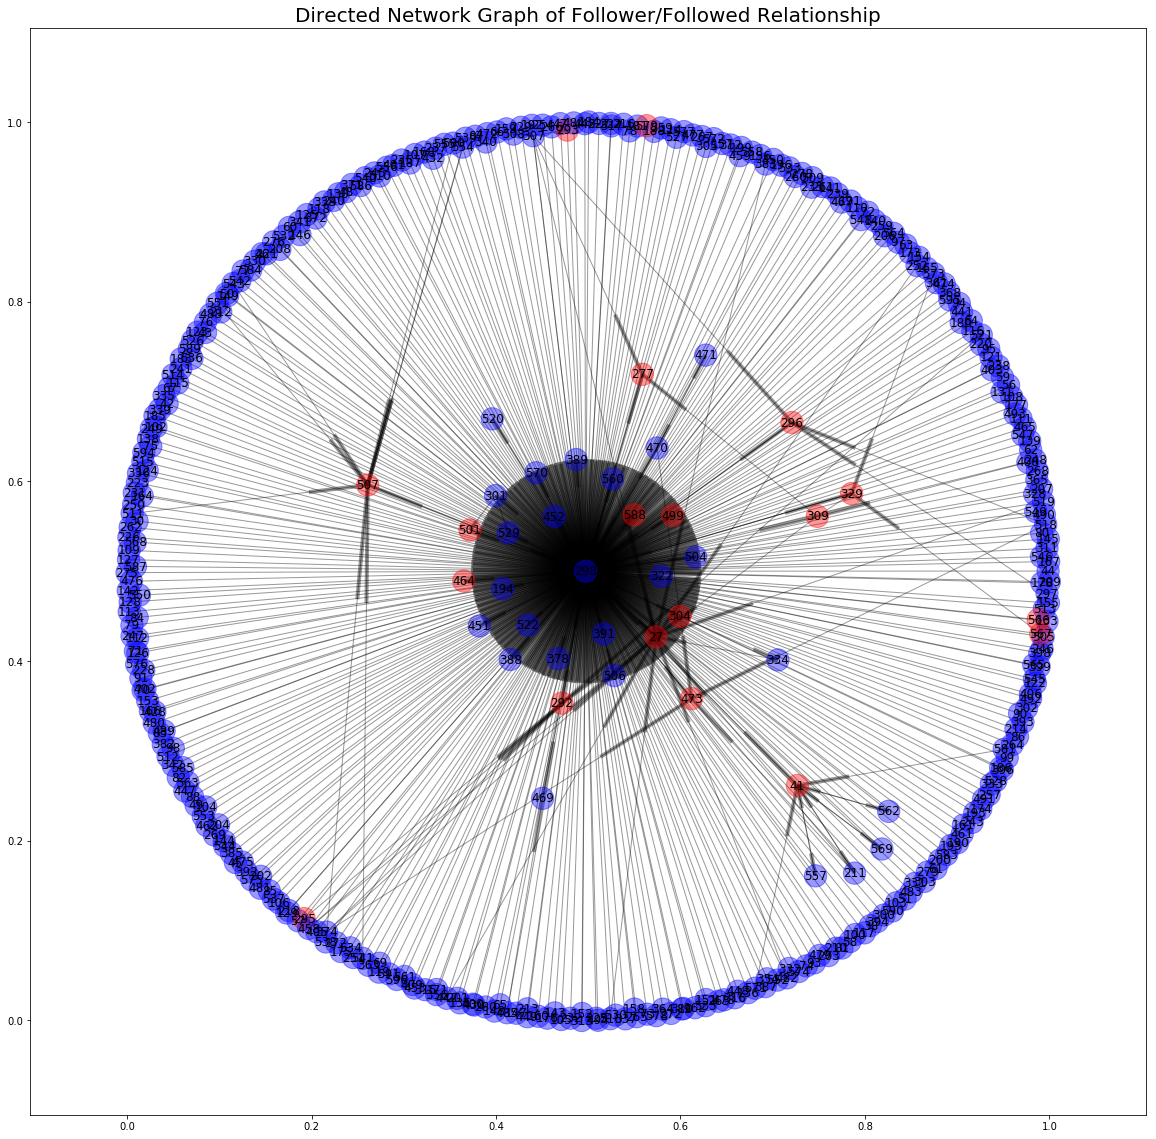

In [181]:
plt.figure(figsize=(20,20))
plt.title('Directed Network Graph of Follower/Followed Relationship', fontsize = 20)
nx.draw_networkx(DG_follow, node_color = follow_colors, node_size = 500, alpha = 0.4)

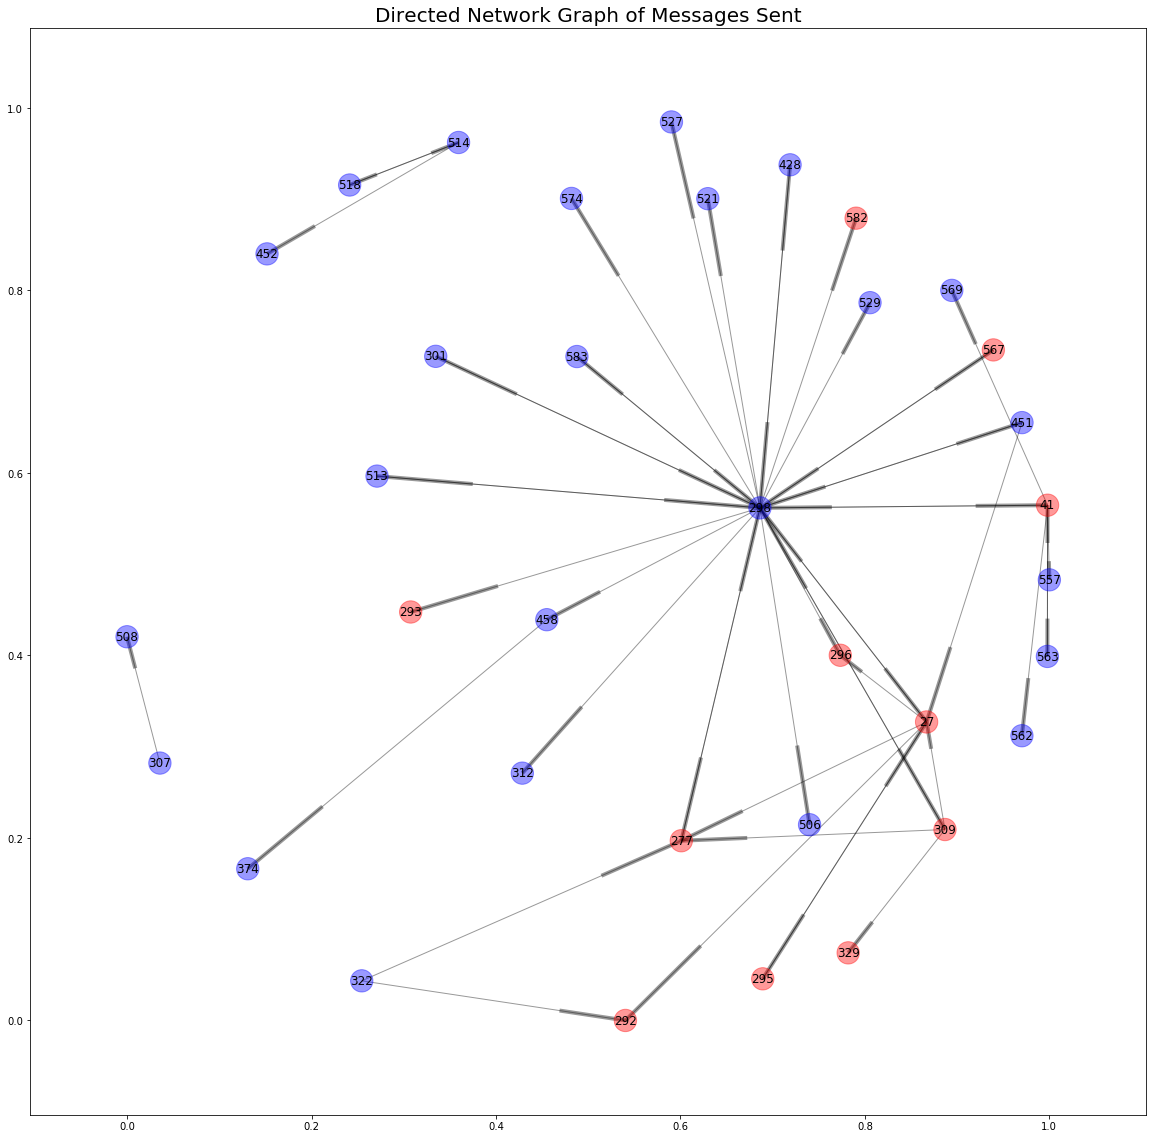

In [182]:
plt.figure(figsize=(20,20))
plt.title('Directed Network Graph of Messages Sent', fontsize = 20)
nx.draw_networkx(DG_message, node_color = message_colors, node_size = 500, alpha = 0.4)

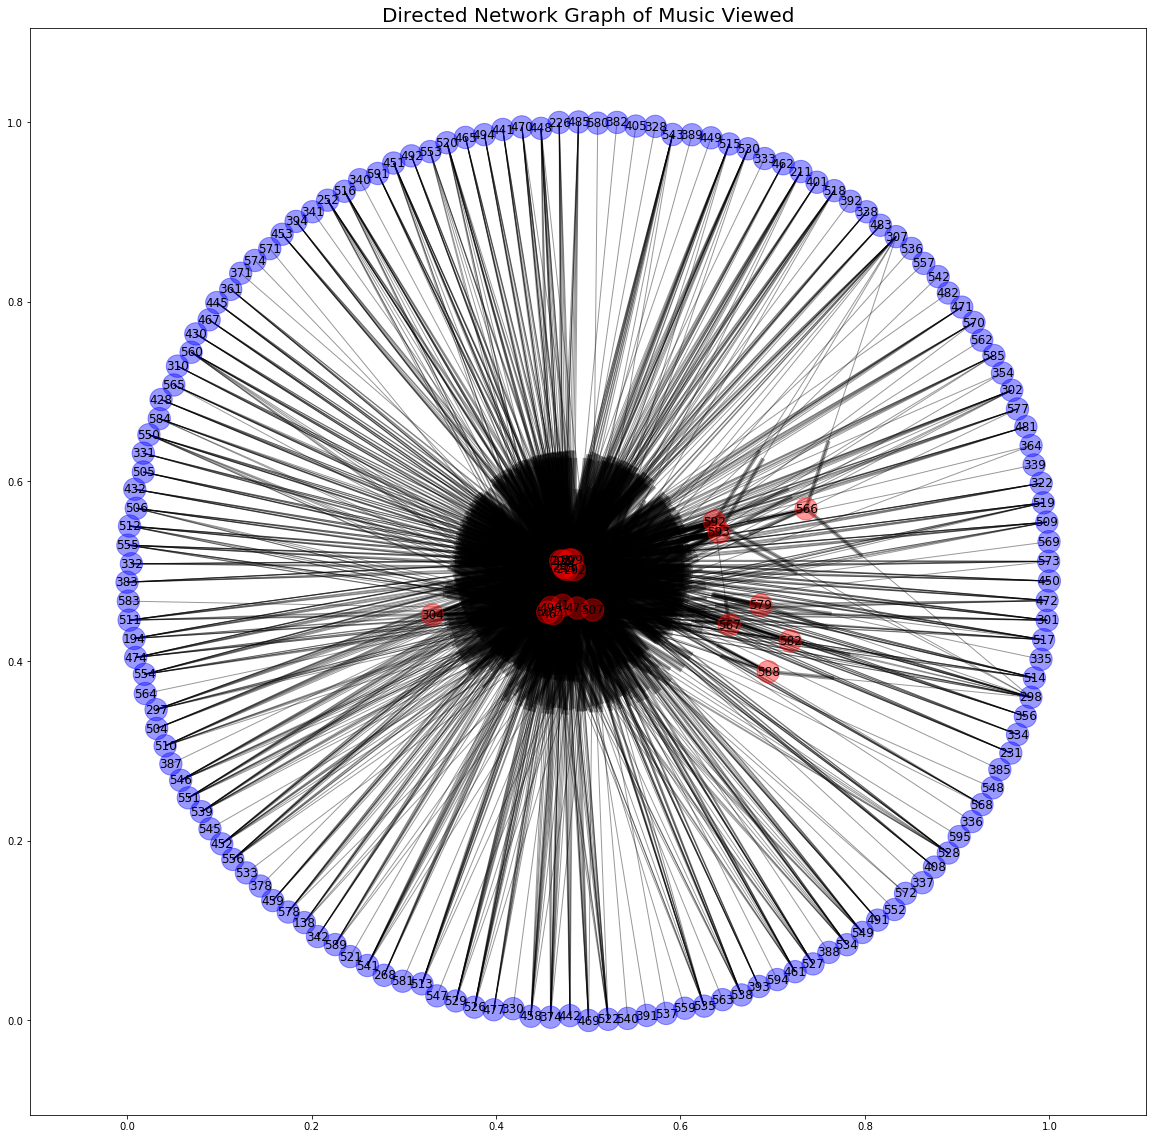

In [183]:
plt.figure(figsize=(20,20))
plt.title('Directed Network Graph of Music Viewed', fontsize = 20)
nx.draw_networkx(DG_view, node_color = view_colors, node_size = 500, alpha = 0.4)

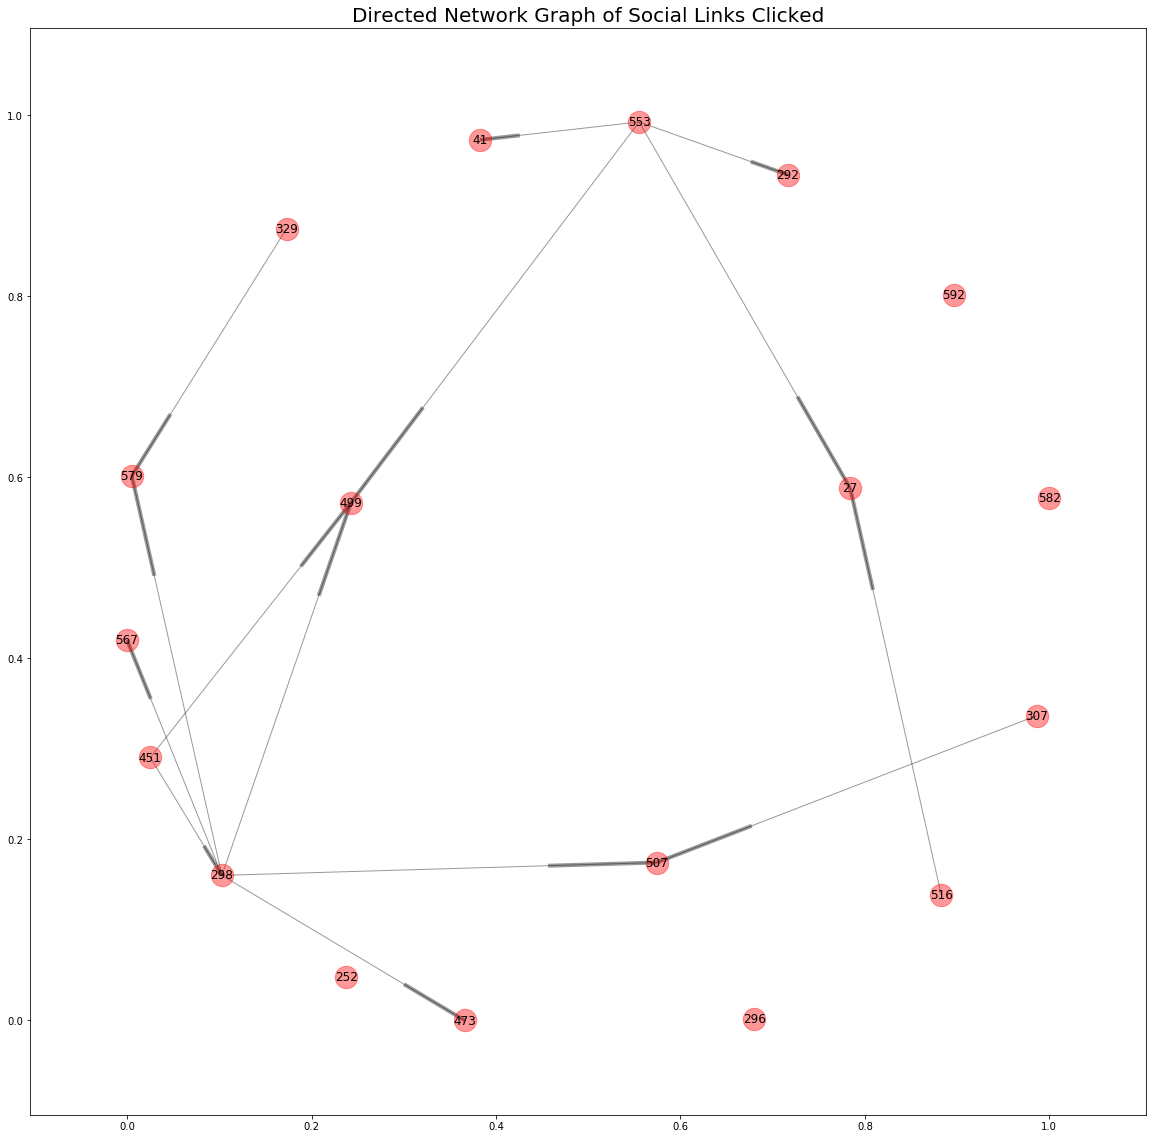

In [184]:
plt.figure(figsize=(20,20))
plt.title('Directed Network Graph of Social Links Clicked', fontsize = 20)
nx.draw_networkx(DG_sociallink, sociallink_color = view_colors, node_size = 500, alpha = 0.4)

<p><a name="centrality1"></a></p>
## Centrality Analysis #1: "Celebrities"

In [186]:
#defines a function that returns a sorted list of people (1st element) and the number of connections (2nd element)
def sorted_map(map):
    sorted_map = sorted(map.items(), key=operator.itemgetter(1), reverse = True) 
    return(sorted_map)


In [197]:
#Define a function that returns top n "celebrities" in form of data frame

def top_degree_artcric (G, n, user_type =None):
    d=nx.degree(G) 
    ds=sorted_map(d)
    ds_critic = []
    ds_artist = []
    
    a_list, c_list = get_artcric_lists(G)
    
    for i in range(0,len(ds)):
        if (ds[i][0] in c_list):
            ds_critic.append(ds[i])
        else:
            ds_artist.append(ds[i])
    
    if (user_type == 'critic'):
        temp = ds_critic
    elif (user_type == 'artist'):
        temp = ds_artist[0:n]
    else:
        temp = ds[0:n]
    
    import heapq
    b = [x[1] for x in temp]
    b_n = min(heapq.nlargest(n, set(b)))
    ans = [x for x in temp if x[1]>=b_n]  
    
    return(pd.DataFrame(ans, columns = ["id", "num_connections"]))

In [200]:
#Test function
n = 5
user_type = 'critic'
print("Top %d %ss by number of connections (%s, #connections):" %(n,user_type, user_type))
top_degree_artcric(G_follow, n, user_type)

Top 5 critics by number of connections (critic, #connections):


id  num_connections
0   298              396
1   307                6
2   374                5
3   458                5
4   518                5
5   211                3
6   301                3
7   470                3
8   334                2
9   442                2
10  452                2
11  469                2
12  471                2
13  482                2
14  485                2
15  508                2
16  511                2
17  516                2
18  517                2
19  519                2
20  520                2
21  521                2
22  529                2
23  538                2
24  539                2
25  541                2
26  543                2
27  551                2
28  554                2
29  557                2
30  560                2
31  562                2
32  565                2
33  569                2
34  571                2
35  573                2
36  580                2
37  581                2

In [201]:
#Test function
n = 5
user_type = 'artist'
print("Top %d %ss by number of connections (%s, #connections):" %(n,user_type, user_type))
top_degree_artcric(G_follow, n, user_type)

Top 5 artists by number of connections (artist, #connections):


id  num_connections
0   27               15
1  507                9
2   41                7
3  292                6
4  309                5

In [202]:
#Test function
n = 5
user_type = 'all user'
print("Top %d %ss by number of connections (%s, #connections):" %(n,user_type, user_type))
top_degree_artcric(G_follow, n, user_type)

Top 5 all users by number of connections (all user, #connections):


id  num_connections
0  298              396
1   27               15
2  507                9
3   41                7
4  292                6

<p><a name="centrality2"></a></p>
## Centrality Analysis #2: "Gossipmongers"

In [205]:
#Function that returns top n "gossipmongers" by critic/artist in form of data frame
    
def top_closeness_artcric(G, n, user_type =None):
    c = nx.closeness_centrality(G)
    cs=sorted_map(c)
    cs_critic = []
    cs_artist = []
    
    a_list, c_list = get_artcric_lists(G)
    
    for i in range(0,len(cs)):
        if (cs[i][0] in c_list):
            cs_critic.append(cs[i])
        else:
            cs_artist.append(cs[i])
    
    if (user_type == 'critic'):
        ans = cs_critic[0:n]
    elif (user_type == 'artist'):
        ans = cs_artist[0:n]
    else:
        ans =cs[0:n]
    return(pd.DataFrame(ans, columns = ["id", "closeness"]))


In [206]:
#Test function
n = 5
user_type = 'critic'
print("Top %d %ss by closeness measure (%s, closeness):" %(n,user_type, user_type))
top_closeness_artcric(G_follow, n, user_type)

Top 5 critics by closeness measure (critic, closeness):


id  closeness
0  298   0.982927
1  307   0.503121
2  458   0.501868
3  442   0.500000
4  482   0.500000

In [207]:
#Test function
n = 5
user_type = 'artist'
print("Top %d %ss by closeness measure (%s, closeness):" %(n,user_type, user_type))
top_closeness_artcric(G_follow, n, user_type)

Top 5 artists by closeness measure (artist, closeness):


id  closeness
0   27   0.508838
1  309   0.502494
2  304   0.501244
3  507   0.501244
4   41   0.500621

In [208]:
#Test function
n = 5
user_type = 'all user'
print("Top %d %ss by closeness measure (%s, closeness):" %(n,user_type, user_type))
top_closeness_artcric(G_follow, n, user_type)

Top 5 all users by closeness measure (all user, closeness):


id  closeness
0  298   0.982927
1   27   0.508838
2  307   0.503121
3  309   0.502494
4  458   0.501868

<p><a name="centrality3"></a></p>
## Centrality Analysis #3: "Boundary Spanners"

In [209]:
#Function that returns top n "boundary spanners" by critic/artist

def top_betweenness_artcric(G, n, user_type=None):
    b = nx.betweenness_centrality(G)
    bs=sorted_map(b)
    bs_critic = []
    bs_artist = []
    
    a_list, c_list = get_artcric_lists(G)
    
    for i in range(0,len(bs)):
        if (bs[i][0] in c_list):
            bs_critic.append(bs[i])
        else:
            bs_artist.append(bs[i])
    
    if (user_type == 'critic'):
        ans = bs_critic[0:n]
    elif (user_type == 'artist'):
        ans = bs_artist[0:n]
    else:
        ans = bs[0:n]
    return(pd.DataFrame(ans, columns = ["id", "betwenness"]))


In [210]:
#Test function
n = 5
user_type = "critic"
print("Top %d %ss by betweenness measure (%s_id, betweenness):" %(n,user_type, user_type))
top_betweenness_artcric(G_follow, n, user_type)

Top 5 critics by betweenness measure (critic_id, betweenness):


id  betwenness
0  298    0.997312
1  458    0.000967
2  307    0.000185
3  374    0.000066
4  211    0.000048

In [211]:
#Test function
n = 5
user_type = "artist"
print("Top %d %ss by betweenness measure (%s_id, betweenness):" %(n,user_type, user_type))
top_betweenness_artcric(G_follow, n, user_type)

Top 5 artists by betweenness measure (artist_id, betweenness):


id  betwenness
0   27    0.015484
1  309    0.005016
2  296    0.004969
3  473    0.002566
4  304    0.002394

In [212]:
#Test function
n = 5
user_type = "all user"
print("Top %d %ss by betweenness measure (%s_id, betweenness):" %(n,user_type, user_type))
top_betweenness_artcric(G_follow, n, user_type)

Top 5 all users by betweenness measure (all user_id, betweenness):


id  betwenness
0  298    0.997312
1   27    0.015484
2  309    0.005016
3  296    0.004969
4  473    0.002566

<p><a name="centrality4"></a></p>
## Centrality Analysis #4: "Gray Cardinals"

In [216]:
# define function that returns top n people by eigenvalue
def top_eigen_artcric(G, n, user_type =None):
    e = nx.eigenvector_centrality_numpy(G)
    es = sorted_map(e)
    
    a_list, c_list = get_artcric_lists(G)
    
    if (es[-1][1]>0):
        es_critic = []
        es_artist = []
        
        for i in range(0,len(es)):
            if (es[i][0] in c_list):
                es_critic.append(es[i])
            else:
                es_artist.append(es[i])
                
        if (user_type == 'critic'):
            ans = es_critic[0:n]
        elif (user_type == 'artist'):
            ans = es_artist[0:n]
        else:
            ans =es[0:n]
        
        return(pd.DataFrame(ans, columns = ["id", "eigenvalue"]))
    else:
        return("No maximum eigenvalue found.")
        

In [217]:
#Test function
n = 5
user_type = 'critic'
print("Top %d %ss by eigenvalue (%s, eigenvalue):" %(n,user_type, user_type))
top_eigen_artcric(G_follow, n, user_type)

Top 5 critics by eigenvalue (critic, eigenvalue):


id  eigenvalue
0  298    0.704038
1  307    0.045520
2  458    0.042567
3  518    0.041150
4  470    0.038973

In [218]:
#Test function
n = 5
user_type = 'artist'
print("Top %d %ss by eigenvalue (%s, eigenvalue):" %(n,user_type, user_type))
top_eigen_artcric(G_follow, n, user_type)

Top 5 artists by eigenvalue (artist, eigenvalue):


id  eigenvalue
0   27    0.054468
1  507    0.050146
2   41    0.044794
3  292    0.043664
4  309    0.041971

In [219]:
#Test function
n = 5
user_type = 'all user'
print("Top %d %ss by eigenvalue (%s, eigenvalue):" %(n,user_type, user_type))
top_eigen_artcric(G_follow, n, user_type)

Top 5 all users by eigenvalue (all user, eigenvalue):


id  eigenvalue
0  298    0.704038
1   27    0.054468
2  507    0.050146
3  307    0.045520
4   41    0.044794

<p><a name="centrality5"></a></p>
## Centrality Analysis #5: Page Rank

In [220]:
#Function that returns top n "boundary spanners" by critic/artist

def top_pagerank_artcric(G, n, user_type=None):
    p = nx.pagerank(G)
    ps=sorted_map(p)
    ps_critic = []
    ps_artist = []
    
    a_list, c_list = get_artcric_lists(G)

    for i in range(0,len(ps)):
        if (ps[i][0] in c_list):
            ps_critic.append(ps[i])
        else:
            ps_artist.append(ps[i])
    
    if (user_type == 'critic'):
        ans = ps_critic[0:n]
    elif (user_type == 'artist'):
        ans = ps_artist[0:n]
    else:
        ans = ps[0:n]
    return(pd.DataFrame(ans, columns = ["id", "page_rank"]))


In [221]:
#Test function
n = 5
user_type = "critic"
print("Top %d %ss by PageRank (%s, page_rank):" %(n,user_type, user_type))
top_pagerank_artcric(G_follow, n, user_type)

Top 5 critics by PageRank (critic, page_rank):


id  page_rank
0  298   0.409157
1  307   0.005192
2  458   0.003957
3  374   0.003810
4  518   0.003485

In [222]:
#Test function
n = 5
user_type = "artist"
print("Top %d %ss by PageRank (%s, page_rank):" %(n,user_type, user_type))
top_pagerank_artcric(G_follow, n, user_type)

Top 5 artists by PageRank (artist, page_rank):


id  page_rank
0   27   0.012177
1  507   0.008099
2   41   0.006226
3  292   0.004797
4  309   0.004456

In [223]:
#Test function
n = 5
user_type = "all user"
print("Top %d %ss by PageRank (%s, page_rank):" %(n,user_type, user_type))
top_pagerank_artcric(G_follow, n, user_type)

Top 5 all users by PageRank (all user, page_rank):


id  page_rank
0  298   0.409157
1   27   0.012177
2  507   0.008099
3   41   0.006226
4  307   0.005192

<p><a name="centrality_summary"></a></p>
## Centrality Analysis: Summary

-- Define function that returns top users for all centrality measures

-- Define function that returns centrality measures for specific user

In [ ]:
#function that returns top n for each of the previous centrality measures in a data frame and sorts by
#number of connections
def topCentral(g, n, user_type):
    df_celeb = getCeleb(g, n, user_type)
    df_close = getClose(g, n, user_type)
    df_span = getSpan(g, n, user_type)
    df_eigen = getEigen(g, n, user_type)
    df_rank = getPgRank(g, n, user_type)
    
    names1 = df_celeb['id']
    names2 = df_close['id']
    names3 = df_span['id']
    
    if(type(df_eigen) == pd.DataFrame):
        names4 = df_eigen['id']
    else:
        names4 = names1
    names5 = df_rank['id']
    names=list(set(names1) | set(names2) | set (names3) | set (names4) | set (names5))
    
    df_celeb2 = getCeleb(g, len(g), user_type)
    df_close2 = getClose(g, len(g), user_type)
    df_span2 = getSpan(g, len(g), user_type)
    df_eigen2 = getEigen(g, len(g), user_type)
    df_rank2 = getPgRank(g, len(g), user_type)
    
    if(type(df_eigen) == pd.DataFrame):    
        table = [[name,df_celeb2.iloc[df_celeb2[df_celeb2['id']==name].index.values.astype(int)[0],1], \
            df_close2.iloc[df_close2[df_close2['id']==name].index.values.astype(int)[0],1], \
            df_span2.iloc[df_span2[df_span2['id']==name].index.values.astype(int)[0],1], \
            df_eigen2.iloc[df_eigen2[df_eigen2['id']==name].index.values.astype(int)[0],1],\
            df_rank2.iloc[df_rank2[df_rank2['id']==name].index.values.astype(int)[0],1]] for name in names] 
    
    else:
        table = [[name,df_celeb2.iloc[df_celeb2[df_celeb2['id']==name].index.values.astype(int)[0],1], \
            df_close2.iloc[df_close2[df_close2['id']==name].index.values.astype(int)[0],1], \
            df_span2.iloc[df_span2[df_span2['id']==name].index.values.astype(int)[0],1], \
            np.nan, df_rank2.iloc[df_rank2[df_rank2['id']==name].index.values.astype(int)[0],1]]
            for name in names] 
    df = pd.DataFrame(table[1:],columns= ['id',df_celeb.columns.get_values()[1], 
                      df_close.columns.get_values()[1], df_span.columns.get_values()[1],
                      "eigenvalue", df_rank.columns.get_values()[1]])
    
    df = df.sort_values(df_celeb.columns.get_values()[1], ascending = False)
    return(df)

In [ ]:
#Test getCentral function by iterating it through the various connection types

#Arguments passed to function
n = 3
user_type = 'critic'
connection = ['follow', 'message', 'view', 'sociallink']

for i in connection:
    df = get_dataframe(i)
    g = get_graph(df)
    g_reduced = filter_graph(g)
    print(i, " connection type", '\n')
    print("Summary of top %ss by various centrality measures, sorted by number of connections:" %( user_type),'\n')
    print(topCentral(g_reduced, n, user_type), '\n')

In [ ]:
#Define function that returns 1) data frame with the various centrality measures for a given user 
# and 2) second data frame with ranks 

def getCentral (user):
    connection = ['follow', 'message', 'view', 'sociallink']
    table1 =[] #table for centrality measures
    table2 =[] #table for centrality ranks
    
    for i in connection:
        temp_df = get_dataframe(i)
        g = get_graph(temp_df)
        g = filter_graph(g)
        
        #code for data frame with centrality measures
        d = nx.degree(g)[user]
        c = nx.closeness_centrality(g)[user]
        b = nx.betweenness_centrality(g)[user]
        p = nx.pagerank(g)[user]
        
        e = nx.eigenvector_centrality_numpy(g)
        es = sorted_map(e)
        
        if (es[-1][1]>0):
            e = nx.eigenvector_centrality_numpy(g)[user]
        else:
            e =np.nan
        
        table1.append([i,d, c, b, e, p])
        
        #code for data frame with centrality ranks
        max_ = len(g.nodes())
        df = getCeleb(g, max_)
        d_rank = df[df['id'] == user].index.values[0]+1
        df = getClose(g, max_)
        c_rank = df[df['id'] == user].index.values[0]+1
        df = getSpan(g, max_)
        b_rank = df[df['id'] == user].index.values[0]+1
        df = getPgRank(g, max_)
        p_rank = df[df['id'] == user].index.values[0]+1
        
        df = getEigen(g, max_)
        if (type(df) == pd.DataFrame):
            e_rank = df[df['id'] == user].index.values[0]+1
        else:
            e_rank =np.nan
            
        table2.append([i,d_rank, c_rank, b_rank, e_rank, p_rank])
     
    df1 = pd.DataFrame(table1, columns = ['connection_type', 'num_connections', 'closeness', 'betweenness', 
                                        'eigenvalue',  'page_rank'])
        
    df1.set_index('connection_type')
    
    df2 = pd.DataFrame(table2, columns = ['connection_type', 'num_connections', 'closeness', 'betweenness', 
                                        'eigenvalue',  'page_rank'])
        
    df2.set_index('connection_type')
    
        
    return df1, df2

In [ ]:
#Test getCentral function
getCentral(27)

<p><a name="ccc"></a></p>
## Components and Subgraphs

#### Subcomponents

In [ ]:
## define function that returns the top n components (graphs objects) by number of nodes
## this can possibly be fed into a pipeline for further analysis of the components
def getComponent(g, n):
    graphs = sorted(nx.connected_component_subgraphs(g), key = len, reverse=True)
    n_nodes = [nx.number_of_nodes(g) for g in graphs]
    
    if (n>len(graphs)):
        return("Number entered exceeds max value of %d. Please try again" %(len(graphs)))
    else:
        import heapq
        min_= min(heapq.nlargest(n, set(n_nodes)))        
        ans = [g for g in graphs if nx.number_of_nodes(g) >=min_]
        return(ans)

In [ ]:
##Test function
e=nx.read_pajek("egypt_retweets.net")
graphs = sorted(nx.connected_component_subgraphs(e),key = len, reverse=True)
n_nodes = [nx.number_of_nodes(g) for g in graphs]
getComponent(e, 5)

#### Islands

In [ ]:
#Define function that removes edges with weights below a certain level and returns
def trim_edges(g, weight=1): 
    g2=nx.Graph()
    for f, to, edata in g.edges(data=True): 
        if (edata['weight']) > weight:
            g2.add_edge(f,to,edata)
        return g2

In [ ]:
#Define a function to gradually trim the network into smaller networks. Returns threshold value and graph object.
#This can possibly be fed into a pipeline for further analysis of the islands.
def island_method(g, iterations=5):
    weights= [edata['weight'] for f,to,edata in g.edges(data=True)]
    mn=int(min(weights))
    mx=int(max(weights))
    step=int((mx-mn)/iterations)
    
    return [[threshold, trim_edges(g, threshold)] for threshold in range(mn,mx,step)]

In [ ]:
#test island_method function on biggest component
cc=getComponent(e,5)[0]
islands=island_method(cc)
islands

#### Ego graphs and networks

In [ ]:
#Define function that returns ego graph object for given user, connection type, depth of search

def getEgo (user, connection, depth):
    df = get_dataframe(connection)
    g = get_graph(df)
    g = filter_graph(g)
    ego = nx.Graph(nx.ego_graph(g,user, radius=depth))
    return ego

In [ ]:
#Test getEgo function
#Draw ego graph

user = getEgo(27, 'follow', 1)

color_map = {}
key_list = user.nodes()

for i in range(0, len(key_list)):
    if(user.node[key_list[i]]['user_type'] == 'critic'):
        color_map[key_list[i]] = 'b'
    else:
        color_map[key_list[i]] = 'r'

        
colors = [color_map.get(node) for node in user.nodes()]

plt.figure(figsize=(20,15))
nx.draw_networkx(user, node_color = colors, node_size = 500, alpha = 0.4)


In [ ]:
#Define function to get df for each user that shows number of connections and portion of connections that are
#connected to each other
def ego_graph_df(connection, user, degree=1):
    
    ego_graph = getEgo(user, connection, degree)
    num = len(ego_graph)
    avg = round(nx.average_clustering(ego_graph),2)
    ans = [[num, avg]]
    return (pd.DataFrame(ans, columns = ["num_connections", "percent_connected"]))

In [ ]:
ego_graph_df('follow',27,1)

### Triads

In [ ]:
#9/11 example from Book. Columns in the "edgelist.text" file, in order, are: 
#1)from, 2) to, 3) strength of tie, 4) level to which tie has been confirmed
#"attrib.txt" file contains the flight each person was on.

import csv 

with open('9_11_edgelist.txt', 'r') as f:
    reader = csv.reader(f) 
    g = nx.Graph()
    for row in reader:
        g.add_edge(row[0],row[1],weight=row[2],conf=row[3])
    
    for n in g.nodes_iter(): 
        g.node[n]['flight']='None'

with open('9_11_attrib.txt', 'r') as f:
    attribute = csv.reader(f) 
    for row in attribute:
        g.node[row[0]]['flight']=row[1]

##Examine largest subcomponent
components=sorted(nx.connected_component_subgraphs(g), key = len, reverse=True)
cc = components[0]

#Plot largest subcomponent. The function reads node attributes and assigns colors to 
#them based on attribute values. "multimode" function is defined in multimode.py file.

from collections import defaultdict
import multimode as mm

plt.figure(figsize=(20,15))
mm.plot_multimode(cc,type_string='flight')

In [ ]:
#Census of triad types using sample data. First number is number of bidirectional edges. 
#Second number is number of single edges. Third number is number of non-existent edges.
import triadic
import draw_triads
g=nx.DiGraph(nx.krackhardt_kite_graph())

census, node_census = triadic.triadic_census(g) 
census

In [ ]:
#Generate table of nodes with number of instances in each of the triad types

keys=node_census[0].keys()
## Generate a table header
print ('| Node |', ' | '.join(keys))
## Generate table contents
## A little magic is required to convert ints to strings 
for k in node_census.keys():
    print ('|', k, '|',' | '.join([str(v) for v in node_census[k].values()]))

In [ ]:
#See which users are in the most closed triads, i.e., cliques. First column is user, second is triads.
#Define function that returns count of closed triads each user is in by type of connection (follow, message)


def getCensus(connection, n, user_type = None):
    df = get_dataframe(i)
    g = get_graph(df)
    g = filter_graph(g)
    
    listeners, artists = bh.users()
    l = listeners['id'].tolist()
    a = artists['id'].tolist()
    l_list = [x for x in l if x in set(g.nodes())] #list of critics 
    a_list = [x for x in a if x in set(g.nodes())]
        
    census, node_census = triadic.triadic_census(g)
    
    if user_type =='critic':
        user_list = list(set(node_census.keys()) & set(l_list))
    elif user_type == 'artist':
        user_list = list(set(node_census.keys()) & set(a_list))
    else:
        user_list = node_census.keys()
    closed_triads=[[v,-k] for k,v in sorted([[-node_census[k]['300'],k] for k in user_list])]
    closed_triads_df = pd.DataFrame(closed_triads, columns = ['id', 'closed_triads'])
    return(closed_triads_df[0:n])

In [ ]:
#Test code
getCensus('follow', 5)

#### Hierarchical Clustering

In [ ]:
import hc

eco=nx.read_pajek("economic.net")
hc.create_hc(eco, 0)

<p><a name="bimodal"></a></p>

## Bimodal Networks

In [9]:
#Parameter: dataframe that user wants to use for creating bipartite graph
#mutates dataframe into one that has negated value for music_id

def negate_musicid_1(df):
    df['user_music_id'] = -1 * df_rating['user_music_id']   

def negate_musicid_2(df):
    df['music_id'] = -1 * df['music_id']

In [10]:
#Parameter: dataframe to create bipartite graph
#Returns: bipartite graph

def get_bigraph_1(df):
    BG = nx.Graph()
    BG.add_nodes_from(df['user_id'], bipartite = 0)
    BG.add_nodes_from(df['user_music_id'], bipartite=1)
    zipped_edges = zip(df['user_id'], df['user_music_id'])
    BG.add_edges_from(zipped_edges)
    return BG

def get_bigraph_2(df):
    BG = nx.Graph()
    BG.add_nodes_from(df['user_id'], bipartite = 0)
    BG.add_nodes_from(df['music_id'], bipartite=1)
    zipped_edges = zip(df['user_id'], df['music_id'])
    BG.add_edges_from(zipped_edges)
    return BG

In [11]:
#Parameter: bipartite graph opbject
#Output: 2 lists: top_nodes and bottom_nodes

def get_bipartite_nodes(BG):
    top_nodes, bottom_nodes = bipartite.sets(B)
    
    top_nodes = {n for n, d in B.nodes(data=True) if d['bipartite']==0}
    bottom_nodes = set(B) - top_nodes
    
    return top_nodes, bottom_nodes

In [12]:
#Parameter: dataframe used for bipartite graph
#Output: 'pos' argument for use for graph axes

def get_pos_1(df):
    pos = {node:[0, i] for i,node in enumerate(df['user_id'])}
    pos.update({node:[1, i] for i,node in enumerate(df['user_music_id'])})
    return pos

def get_pos_2(df):
    pos = {node:[0, i] for i,node in enumerate(df['user_id'])}
    pos.update({node:[1, i] for i,node in enumerate(df['music_id'])})
    return pos

In [ ]:
def get_userlists(df):
    userlist = sorted(set(df['user_id'].tolist()))
    return userlist

def get_musiclists_1(df):
    musiclist = sorted(set(df['user_music_id'].tolist()))
    return musiclist

def get_musiclists_2(df):
    musiclist = sorted(set(df['music_id'].tolist()))
    return musiclist

In [19]:
#get dataframes for all four 2-mode networks
df_rating = get_dataframe('rating')
df_save = get_dataframe('save')
df_spotlight = get_dataframe('spotlight')
df_comment = get_dataframe('comment')

In [20]:
df_rating

user_id  user_music_id  rating           date_added
0        298             15       4  2017-09-14 13:19:12
1        298             16       4  2017-09-14 13:19:25
2        298              7       5  2017-09-14 16:25:09
3        298             17       4  2017-09-15 16:25:11
4        296              7       5  2017-09-15 16:30:55
5        277              9       4  2017-09-18 08:42:26
6        277             10       5  2017-09-18 08:43:01
7        342             22       5  2017-09-18 11:04:56
8        307              9       5  2017-09-19 23:50:38
9        307             14       5  2017-09-20 00:01:44
10       334              7       5  2017-09-20 06:04:01
11       334              9       5  2017-09-20 06:53:55
12       334             10       5  2017-09-20 06:54:14
13       334             15       5  2017-09-20 06:54:40
14       334             16       5  2017-09-20 06:54:45
15       334             17       5  2017-09-20 06:54:49
16        27              7       5  2017-09-20 17:22:01
17       298             22       5  2017-09-20 17:27:51
18        27             18       5  2017-09-20 17:32:58
19        27             14       5  2017-09-20 17:48:00
20        27             21       4  2017-09-20 17:50:50
21        27             22       5  2017-09-20 17:50:54
22        27             23       3  2017-09-20 17:50:59
23        27             32       4  2017-09-20 17:51:37
24        27             33       4  2017-09-20 17:51:41
25        27             35       5  2017-09-20 17:51:57
26        27             20       5  2017-09-21 03:51:48
27       298              9       3  2017-09-21 21:32:01
28        27             15       5  2017-09-26 13:04:51
29       357             18       5  2017-09-26 21:12:19
30       357              7       4  2017-09-26 21:12:28
31       357             19       3  2017-09-26 21:12:36
32       357             29       1  2017-09-26 21:12:52
33       361             32       3  2017-09-27 15:34:24
34       307              7       5  2017-09-27 18:27:15
35       307             18       5  2017-09-27 18:28:31
36       307             19       3  2017-09-27 18:29:17
37       307             20       5  2017-09-27 18:33:03
38       298             21       4  2017-10-03 13:14:59
39       309             21       5  2017-10-06 08:58:20
40       309             22       2  2017-10-06 08:59:23
41       309             18       5  2017-10-06 09:11:53
42       309              9       5  2017-10-06 09:29:37
43       309             10       5  2017-10-06 09:29:44
44       309             11       2  2017-10-06 09:29:49
45       309             33       5  2017-10-06 09:30:52
46       309             23       5  2017-10-06 10:24:56
47       309             24       5  2017-10-06 10:26:04
48       371             25       1  2017-10-11 13:53:28
49       371             26       1  2017-10-11 13:54:12
50       304             44       5  2017-10-12 08:44:46
51       304              7       5  2017-10-12 08:46:40
52       356             44       5  2017-10-12 09:58:29
53       357             44       3  2017-10-12 10:17:56
54       373             44       5  2017-10-12 10:19:08
55       374             44       5  2017-10-12 10:19:53
56       373             11       5  2017-10-12 10:22:36
57       373              9       5  2017-10-12 10:22:47
58       373             15       3  2017-10-12 10:24:16
59       373             16       3  2017-10-12 10:24:26
60       298             18       5  2017-10-12 10:33:09
61       298             44       5  2017-10-12 12:20:42
62       378             44       4  2017-10-12 12:41:25
63       379             44       5  2017-10-12 12:57:41
64       382             44       1  2017-10-12 13:11:30
65       383              9       5  2017-10-12 13:47:42
66       322             44       5  2017-10-12 15:21:21
67       383             10       4  2017-10-12 15:24:47
68       383             11       3  2017-10-12 15:25:37
69       383   

In [21]:
# negate value of music_id column to make 2 non-intersecting sets 
# of node values: user_id, music_id
negate_musicid_1(df_rating)
negate_musicid_2(df_save)
negate_musicid_2(df_spotlight)
negate_musicid_1(df_comment)

In [22]:
df_spotlight

music_id user_id          date_added
0         -7      27 2017-09-18 07:42:30
1        -18      27 2017-09-18 07:42:34
2        -19      27 2017-09-18 07:42:40
3         -9      27 2017-09-18 07:43:25
4        -10      27 2017-09-18 07:43:28
5        -10     277 2017-09-18 08:08:39
6        -49     570 2017-11-30 13:01:58
7         -9     307 2017-09-19 23:50:10
8         -7     334 2017-09-20 06:04:08
9        -21     309 2017-10-06 09:00:24
10       -53     211 2017-11-28 15:38:47
11       -44     373 2017-10-12 10:20:46
12        -7     393 2017-10-17 10:43:50
13        -7     373 2017-11-08 08:39:24
14        -7     374 2017-11-08 08:41:31
15       -29     373 2017-11-08 08:46:22
16       -41     373 2017-11-08 08:50:22
18       -45     379 2017-11-08 09:01:37
19       -39     373 2017-11-08 09:18:27
20       -14     374 2017-11-08 11:25:32
21       -27     307 2017-11-08 21:58:53
22       -18     307 2017-11-08 22:56:17
23        -7     307 2017-11-08 22:56:34
24       -17     307 2017-11-08 23:35:49
25       -16     307 2017-11-08 23:38:49
26       -14     298 2017-11-12 21:58:53
27       -17     298 2017-11-12 21:59:42
28       -52     513 2017-11-26 11:59:00
29        -7     458 2017-11-22 07:34:57
30       -18     460 2017-11-20 07:18:52
31       -20     460 2017-11-20 07:20:01
32       -15     452 2017-11-20 19:22:57
33       -53     469 2017-11-21 00:21:16
34       -17     469 2017-11-21 00:26:11
35       -48     469 2017-11-21 00:29:37
36       -19     469 2017-11-21 00:30:59
37       -18     469 2017-11-21 00:31:19
38       -29     469 2017-11-21 00:31:58
39        -9     469 2017-11-21 00:35:01
40       -10     469 2017-11-21 00:35:59
41       -54     469 2017-11-21 00:39:14
42       -14     469 2017-11-21 00:39:54
43       -48     298 2017-11-25 15:43:24
44       -29     470 2017-11-21 00:53:25
45       -39     452 2017-11-21 07:28:49
46       -50     304 2017-11-23 20:57:48
47       -48     304 2017-11-23 20:58:05
48       -53     304 2017-11-23 20:58:19
49       -36     298 2017-11-25 15:41:05
50       -53     298 2017-11-25 15:43:14
51       -45      41 2017-11-26 12:15:49
52       -54      41 2017-11-26 12:16:00
53       -16     451 2017-11-27 05:18:37
54       -53     516 2017-11-27 10:58:24
55       -53      27 2017-11-28 10:34:45
56       -18     309 2017-11-28 13:12:38
57       -54     211 2017-11-28 15:47:16
58       -60     533 2017-11-29 08:54:58
59       -60     298 2017-11-29 19:22:50
60       -29      27 2017-12-01 01:26:20
61       -37     520 2017-12-01 11:20:16
62       -63     298 2017-12-01 13:18:53
63       -63      41 2017-12-01 14:42:32
64       -63     470 2017-12-01 23:38:08
65       -63     518 2017-12-04 10:09:17
66       -15     518 2017-12-04 10:13:47
67      -518     518 2017-12-04 10:20:36
68       -67     329 2017-12-04 18:08:43
69       -65     329 2017-12-04 18:09:26
70       -66     329 2017-12-04 18:09:29

In [23]:
# Get bipartite graphs of each 2-mode connection type
BG_rating = get_bigraph_1(df_rating)
BG_save = get_bigraph_2(df_save)
BG_spotlight = get_bigraph_2(df_spotlight)
BG_comment = get_bigraph_1(df_comment)

In [24]:
# Get lists for top and bottom nodes for each bipartite graph
rating_top, rating_bottom = get_bipartite_nodes(BG_rating)
save_top, save_bottom = get_bipartite_nodes(BG_save)
spotlight_top, spotlight_bottom = get_bipartite_nodes(BG_spotlight)
comment_top, comment_bottom = get_bipartite_nodes(BG_comment)

NameError: name 'B' is not defined

In [ ]:
# get positional info for how to plot nodes of bipartite graph
rating_pos = get_pos_1(df_rating)
save_pos = get_pos_2(df_save)
spotlight_pos = get_pos_2(df_spotlight)
comment_pos = get_pos_1(df_comment)

In [ ]:
plt.figure(figsize=(15,50))
nx.draw_networkx(BG_rating, rating_pos, node_size = 500, alpha = 0.3)

In [ ]:
plt.figure(figsize=(15,50))
nx.draw_networkx(BG_save, save_pos, node_size = 500, alpha = 0.3)

In [ ]:
plt.figure(figsize=(15,50))
nx.draw_networkx(BG_spotlight, spotlight_pos, node_size = 500, alpha = 0.3)

In [ ]:
plt.figure(figsize=(15,50))
nx.draw_networkx(BG_comment, comment_pos, node_size = 500, alpha = 0.3)

In [ ]:
WPG_rating_user = bipartite.weighted_projected_graph(BG_rating, rating_top)
WPG_rating_music = bipartite.weighted_projected_graph(BG_rating, rating_bottom)
WPG_save_user = bipartite.weighted_projected_graph(BG_rating, save_top)
WPG_save_music = bipartite.weighted_projected_graph(BG_rating, save_bottom)
WPG_spotlight_user = bipartite.weighted_projected_graph(BG_rating, spotlight_top)
WPG_spotlight_music = bipartite.weighted_projected_graph(BG_rating, spotlight_bottom)
WPG_comment_user = bipartite.weighted_projected_graph(BG_rating, comment_top)
WPG_comment_music = bipartite.weighted_projected_graph(BG_rating, comment_bottom)

In [ ]:
plt.figure(figsize=(15,50))
nx.draw_networkx(WPG_rating_user, node_size = 500, alpha = 0.3)

In [ ]:
plt.figure(figsize=(15,50))
nx.draw_networkx(WPG_rating_music, node_size = 500, alpha = 0.3)

In [ ]:
plt.figure(figsize=(15,50))
nx.draw_networkx(WPG_save_user, node_size = 500, alpha = 0.3)

In [ ]:
plt.figure(figsize=(15,50))
nx.draw_networkx(WPG_save_music, node_size = 500, alpha = 0.3)

In [ ]:
plt.figure(figsize=(15,50))
nx.draw_networkx(WPG_spotlight_user, node_size = 500, alpha = 0.3)

In [ ]:
plt.figure(figsize=(15,50))
nx.draw_networkx(WPG_spotlight_music, node_size = 500, alpha = 0.3)

In [ ]:
plt.figure(figsize=(15,50))
nx.draw_networkx(WPG_comment_user, node_size = 500, alpha = 0.3)

In [ ]:
plt.figure(figsize=(15,50))
nx.draw_networkx(WPG_comment_music, node_size = 500, alpha = 0.3)

In [ ]:
userlist_rating = get_userlists(df_rating)
musiclist_rating = get_musiclists1(df_rating)
userlist_comments = get_userlists(df_comments)
musiclist_comments = get_musiclists1(df_comments)
userlist_spotlighted = get_userlists(df_spotlighted)
musiclist_spotlighted = get_musiclists2(df_spotlighted)
userlist_saved = get_userlists(df_saved)
musiclist_saved = get_musiclists2(df_saved)

In [ ]:
music_rating_net = bi.weighted_projected_graph(GR, musiclist_rating, ratio = False)

In [ ]:
nx.is_connected(BG_rating)

In [ ]:
nx.is_bipartite(BG_rating)

In [ ]:
bottom_nodes, top_nodes = bipartite.sets(B)

In [ ]:
bottom_nodes, top_nodes = bipartite.sets(B)
top_nodes = {n for n, d in B.nodes(data=True) if d['bipartite']==0}
bottom_nodes = set(B) - top_nodes

In [ ]:
G=bipartite.projected_graph(B, top_nodes)

In [ ]:
bipartite.color(B)

In [ ]:
pos = {node:[0, i] for i,node in enumerate(df_rating['user_id'])}
pos.update({node:[1, i] for i,node in enumerate(df_rating['user_music_id'])})

In [ ]:
print(list(enumerate(df_rating['user_id'])))

In [ ]:
plt.figure(figsize=(15,50))
nx.draw_networkx(B, pos, node_size = 500, alpha = 0.3)

In [ ]:
B

In [ ]:
plt.figure(figsize=(20,15))
nx.draw_networkx(B, node_size = 500, alpha = 0.3)